# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [274]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

## Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [213]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize


In [268]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        # your code here
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.gamma = 1
        self.array_trees = []
        
       
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        self.composition = np.zeros(y.shape[0]) 
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # your code here
        for _ in range(self.n_estimators):
            y_new = self._fit_predict_tree(x, y - self.composition)
            self.composition += y_new

    def _fit_predict_tree(self, x, y):
        tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=123).fit(x, y)
        self.array_trees.append(tree)      
        return self.gamma * self.learning_rate * tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        y_pred = np.zeros(x.shape[0])
        for tree in self.array_trees:
            y_pred += self.gamma * self.learning_rate * tree.predict(x) 
        return y_pred

Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [269]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [270]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [271]:
np.random.seed(19052019)

gb = GradientBoosting(n_estimators = 288, max_depth = 6, learning_rate=0.09)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [272]:
mean_squared_error(y_test, y_pred)

9.910877407395994

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да / Нет

### Нет

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [310]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [311]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [279]:
# Референс

from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

C:\Users\hp\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:12:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7005050108587028

In [287]:
from catboost import CatBoostClassifier

In [321]:
X_train = train.iloc[:,:-1].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)
car_features = [0, 1, 2, 4, 5, 6]

In [322]:
model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.3,
)
model.fit(
    X_train_part, y_train_part, 
    cat_features=cat_features,
    eval_set=(X_valid, y_valid),
    verbose=False
)

In [323]:
roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

0.7492817848638286

## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [324]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [840]:
base = []

In [847]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        # your code here
        self.eps = eps
        self.min_samples = min_samples
        
    def fit_predict(self, X):
        self.answer = np.zeros(X.shape[0])
        self.X = X
        self.check = set(range(X.shape[0]))
        noise = -1
        label_generator = 1
        for point in range(len(X)):
            if point in self.check:
                label_generator += 1
                neighbours = self.range_query(self.X[point], self.check)
                if len(neighbours) < self.min_samples:
                    self.answer[point] = noise
                else:
                    self.grow_cluster(point, neighbours, label_generator)
                    base.append(point) # для теста корректности
        print(self.check)
        return self.answer

    def grow_cluster(self, root, neighbours, label):
        self.answer[root] = label
        self.check.discard(root)
        for point in neighbours:
            if point in self.check:
                self.answer[point] = label
                new_neighbours = self.range_query(self.X[point], self.check) 
                if len(new_neighbours) >= self.min_samples:
                    self.grow_cluster(point, new_neighbours, label)
                    base.append(point) # для теста корректности
                else:
                    self.check.discard(point)
                    
                    
                
    def range_query(self, x, X):
        """Возвращает точки на расстоянии <= eps от x"""
        array = list()
        for j in X:
            if self.dist(x, self.X[j]) <= self.eps:
                array.append(j)
        return array
    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        return distance.euclidean(a, b)

Проверим себя на простом примере:

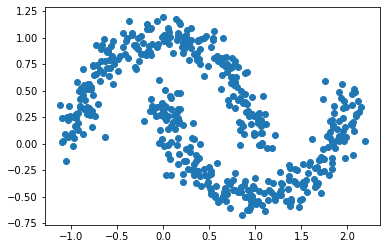

In [657]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

data, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(data[:,0], data[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

##### Получается немного странно, потому что при одинаковом подборе параметром под кастомный dbscan и библиотечный, мы получаем разные картинки. Поэтому я подумал, что скорее всего ошибка у меня, и решил проверить следующим образом: я решил сохранить в список все элементы, которые будут основными, и вывести те точки, которые у нас остались шумовыми. Далее, вспоминая алгоритм, шумовая точка может принадлежать к какому-то кластеру, если расстояние от нее до основной точки будет меньше заданного эпсилона. Чуть ниже я пробежался циклом по всем шумовым и основным точкам, и выяснил, что расстояния между всеми комбинациями будет больше заданного эпсилона 0.2, поэтому дальше я решил подобрать оптимальный эпсилон, что кластеризация для 2х разных dbscan'ов совпадала.

{22, 190, 195, 464, 495}


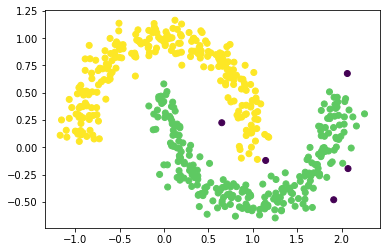

In [848]:
my_cluster = dbscan(eps=0.2, min_samples=10).fit_predict(data)
plt.scatter(data[:,0], data[:,1], c=my_cluster)
plt.show()

In [849]:
for noise in [22, 190, 195, 464, 495]:
    for base_elem in base:
        if distance.euclidean(data[noise], data[base_elem]) <= 0.2:
            print('There is a mistake!')

{22, 195}


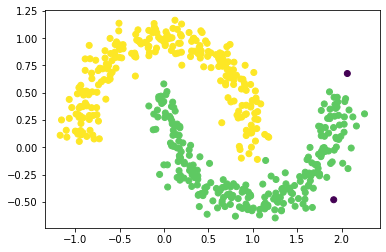

In [850]:
my_cluster = dbscan(eps=0.23, min_samples=10).fit_predict(data)
plt.scatter(data[:,0], data[:,1], c=my_cluster)
plt.show()

##### Теперь картинки совпадают

Референс:

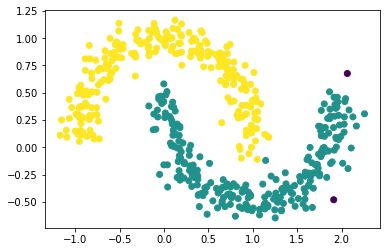

In [814]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(data)

plt.scatter(data[:,0], data[:,1], c=clusters)
plt.show()

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

In [718]:
from sklearn import cluster, datasets

In [797]:
n_samples = 1500
t = 0.1 * np.pi * (1 + 50 * np.random.rand(1, n_samples))
x = t * np.cos(t)
y = t * np.sin(t)

circles = list(datasets.make_circles(n_samples=500, factor=0.8,
                                      noise=.01))
X = np.concatenate((x, y))
X += .1 * np.random.randn(2, n_samples)
X = X.T
X[:, 0] += 7
moon, _ = make_moons(n_samples=100, noise=0.001)
moon[:, 0] -= 8.5
moon[:, 0] *= 2
moon[:, 1] *= 6
circles[0] *= 30
X = np.concatenate((X, moon, circles[0]))

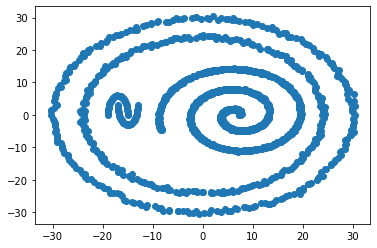

In [798]:
plt.scatter(X[:, 0], X[:, 1])

Или хотя бы что-нибудь такое: 

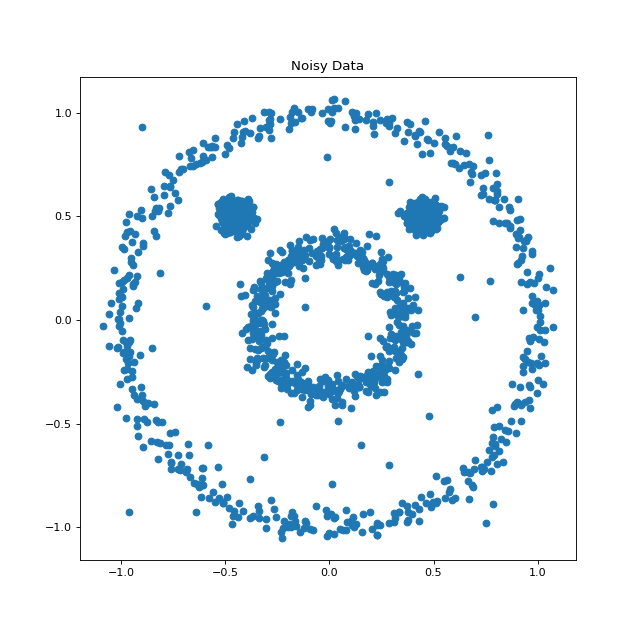

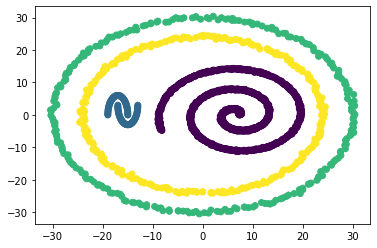

In [809]:
my_cluster = dbscan(eps=3.5, min_samples=5).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=my_cluster)
plt.show()

Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:

In [845]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(data)

Wall time: 6 ms


In [846]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(data)

Wall time: 1.82 s


##### Нууу, почти ...